In [6]:
def load_data_from_directory(directory):
    """
    从指定目录加载段落级别的文本数据。
    """
    documents = []
    file_paths = glob.glob(os.path.join(directory, '*.txt'))
    file_count = len(file_paths)    # 添加文件计数

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            paragraphs = re.split(r'Paragraph \d+:\n', content)
            paragraphs = [p.strip() for p in paragraphs if p.strip()]
            for i, para in enumerate(paragraphs):
                documents.append({
                    "file_name": os.path.basename(file_path),
                    "paragraph_id": i + 1,
                    "content": para
                })
    return documents, file_count    # 返回文档列表和文件数

# 加载完整数据集和测试集
full_dataset, full_file_count = load_data_from_directory('data/preprocessed/cltk')
testset, test_file_count = load_data_from_directory('data/testset/cltk_testset')

print(f"完整数据集文件数：{full_file_count}, 段落总数：{len(full_dataset)}")
print(f"测试集文件数：{test_file_count}, 段落总数：{len(testset)}")

完整数据集文件数：306, 段落总数：4515
测试集文件数：30, 段落总数：512


In [7]:
from gensim import corpora, models
from collections import defaultdict
import numpy as np

def calculate_tfidf_distribution(documents):
    """
    计算所有文件的 TF-IDF 值分布。
    """
    texts = [doc['content'].split() for doc in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    tfidf_model = models.TfidfModel(corpus)
    tfidf_values = defaultdict(float)
    corpus_tfidf = tfidf_model[corpus]

    for doc in corpus_tfidf:
        for term_id, value in doc:
            tfidf_values[term_id] += value

    # 计算全局分布
    num_docs = len(corpus_tfidf)
    tfidf_distribution = {term_id: value / num_docs for term_id, value in tfidf_values.items()}
    return tfidf_distribution, dictionary


In [8]:
# 在测试集上计算 TF-IDF 分布
testset_tfidf_distribution, testset_dictionary = calculate_tfidf_distribution(testset)
testset_tfidf_values = list(testset_tfidf_distribution.values())

# 在完整数据集上计算 TF-IDF 分布
full_dataset_tfidf_distribution, full_dataset_dictionary = calculate_tfidf_distribution(full_dataset)
full_dataset_tfidf_values = list(full_dataset_tfidf_distribution.values())

# 打印统计信息
print(f"测试集 TF-IDF: 最小值={min(testset_tfidf_values):.4f}, 最大值={max(testset_tfidf_values):.4f}, 中位数={np.median(testset_tfidf_values):.4f}")
print(f"完整数据集 TF-IDF: 最小值={min(full_dataset_tfidf_values):.4f}, 最大值={max(full_dataset_tfidf_values):.4f}, 中位数={np.median(full_dataset_tfidf_values):.4f}")


测试集 TF-IDF: 最小值=0.0001, 最大值=0.0263, 中位数=0.0005
完整数据集 TF-IDF: 最小值=0.0000, 最大值=0.0253, 中位数=0.0001


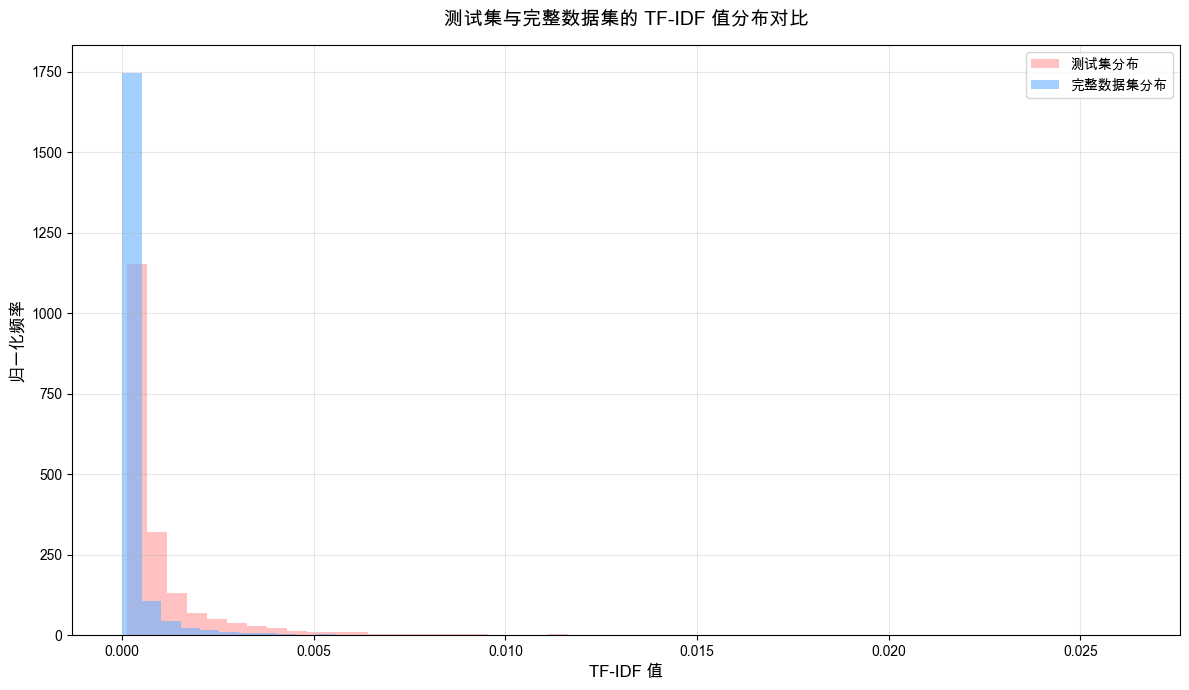

In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # MacOS 用户
# plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 用户
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建图表
plt.figure(figsize=(12, 7))

# 设置颜色
colors = ['#FF9999', '#66B2FF']

# 绘制直方图
plt.hist(testset_tfidf_values, bins=50, alpha=0.6, color=colors[0], 
         label='测试集分布', density=True)
plt.hist(full_dataset_tfidf_values, bins=50, alpha=0.6, color=colors[1], 
         label='完整数据集分布', density=True)

# 添加网格
plt.grid(True, alpha=0.3)

# 美化图表
plt.xlabel('TF-IDF 值', fontsize=12)
plt.ylabel('归一化频率', fontsize=12)
plt.title('测试集与完整数据集的 TF-IDF 值分布对比', fontsize=14, pad=15)
plt.legend(fontsize=10)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [11]:
def count_words(documents):
    """
    统计文档集合中的总词数和独特词数
    """
    total_words = 0
    unique_words = set()
    
    for doc in documents:
        words = doc['content'].split()
        total_words += len(words)
        unique_words.update(words)
    
    return total_words, len(unique_words)

# 统计完整数据集
full_total_words, full_unique_words = count_words(full_dataset)
print(f"完整数据集统计：")
print(f"- 总词数：{full_total_words:,}")
print(f"- 独特词数：{full_unique_words:,}")

# 统计测试集
test_total_words, test_unique_words = count_words(testset)
print(f"\n测试集统计：")
print(f"- 总词数：{test_total_words:,}")
print(f"- 独特词数：{test_unique_words:,}")

# 计算词汇重叠
test_vocab = set(word for doc in testset for word in doc['content'].split())
full_vocab = set(word for doc in full_dataset for word in doc['content'].split())
overlap_vocab = test_vocab.intersection(full_vocab)

print(f"\n词汇重叠：")
print(f"- 重叠词数：{len(overlap_vocab):,}")
print(f"- 测试集词汇覆盖率：{len(overlap_vocab)/len(test_vocab):.2%}")

完整数据集统计：
- 总词数：281,540
- 独特词数：16,959

测试集统计：
- 总词数：29,230
- 独特词数：4,471

词汇重叠：
- 重叠词数：4,471
- 测试集词汇覆盖率：100.00%


In [12]:
# 计算完整数据集分位数阈值
low_threshold = np.percentile(full_dataset_tfidf_values, 50)  # 中位数
medium_threshold = np.percentile(full_dataset_tfidf_values, 80)  # 80% 分位数
high_threshold = np.percentile(full_dataset_tfidf_values, 90)  # 90% 分位数

print(f"低阈值: {low_threshold:.4f}, 中等阈值: {medium_threshold:.4f}, 高阈值: {high_threshold:.4f}")


低阈值: 0.0001, 中等阈值: 0.0003, 高阈值: 0.0006
